In [1]:
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import sys
sys.path.append('./../code/')
from utilities import truncatedNormal
from getData import *
import h5py

In [2]:
# Load inference data, as well as posterior samples and injections
hdata = h5py.File("../data/ar_lnm1_q_summary.hdf",'r')
injectionDict = getInjections(sample_limit=50000,reweight=False)
sampleDict = getSamples(sample_limit=3000,bbh_only=True,reweight=False)

# Sets of sample locations at which rates are inferred
m1s = hdata['posterior/m1s']
qs = hdata['posterior/qs']

# Extract injection data
m1_inj = injectionDict['m1']
m2_inj = injectionDict['m2']
a1_inj = injectionDict['a1']
a2_inj = injectionDict['a2']
cost1_inj = injectionDict['cost1']
cost2_inj = injectionDict['cost2']
z_inj = injectionDict['z']
dVdz_inj = injectionDict['dVdz']
inj_prior = injectionDict['p_draw_m1m2z']*injectionDict['p_draw_a1a2cost1cost2']
q_inj = m2_inj/m1_inj

Removing  GW170817
Removing  S190425z
Removing  S190426c
Removing  S190814bv
Removing  S190917u
Removing  S200105ae
Removing  S200115j


## Create "observed" and "predicted" catalogs of BBH events

In [3]:
# Number of predicted and observed catalogs to consider
nPops = 1000

# Instantiate arrays to hold collections of effective spin values predicted by the fitted model,
# and "observed" values drawn from reweighted posteriors
observed_m1s = np.zeros((nPops,len(sampleDict)))
observed_qs = np.zeros((nPops,len(sampleDict)))
predicted_m1s = np.zeros((nPops,len(sampleDict)))
predicted_qs = np.zeros((nPops,len(sampleDict)))

# Loop across desired number of catalogs
for i in range(nPops):
    
    # Extract effective spin distribution and mass/mass-ratio/redshift hyperparameters
    f_lnm1s = hdata['posterior/f_lnm1s'][:,i]
    f_qs = hdata['posterior/f_qs'][:,i]
    kappa = hdata['posterior/kappa'][i]
    mu_chi = hdata['posterior/mu_chi'][i]
    logsig_chi = hdata['posterior/logsig_chi'][i]
    sig_cost = hdata['posterior/sig_cost'][i]
    
    # Compute proposed population at injection locations
    f_inj_m1 = np.interp(m1_inj,m1s,f_lnm1s)/m1_inj
    f_inj_m2 = np.interp(q_inj,qs,f_qs)/m1_inj
    f_inj_z = dVdz_inj*(1.+z_inj)**(kappa-1.)
    p_inj_a1 = truncatedNormal(a1_inj,mu_chi,10.**logsig_chi,0,1)
    p_inj_a2 = truncatedNormal(a2_inj,mu_chi,10.**logsig_chi,0,1)
    p_inj_cost1 = truncatedNormal(cost1_inj,1.,sig_cost,-1,1)
    p_inj_cost2 = truncatedNormal(cost2_inj,1.,sig_cost,-1,1)
    
    # Randomly draw injections from proposed population
    draw_probs = np.array((f_inj_m1*f_inj_m2*f_inj_z*p_inj_a1*p_inj_a2*p_inj_cost1*p_inj_cost2/inj_prior))
    draw_probs /= draw_probs.sum()
    predicted_ind = np.random.choice(np.arange(draw_probs.size),size=len(sampleDict),p=draw_probs,replace=True)
    predicted_m1s[i,:] = m1_inj[predicted_ind]
    predicted_qs[i,:] = m2_inj[predicted_ind]/m1_inj[predicted_ind]
    
    # Now loop across events
    for ii,event in enumerate(sampleDict):
        
        # Read out parameters
        m1 = sampleDict[event]['m1']
        m2 = sampleDict[event]['m2']
        z = sampleDict[event]['z']
        dVdz = sampleDict[event]['dVc_dz']
        a1 = sampleDict[event]['a1']
        a2 = sampleDict[event]['a2']
        cost1 = sampleDict[event]['cost1']
        cost2 = sampleDict[event]['cost2']
        z_prior = sampleDict[event]['z_prior']
        q = m2/m1
        
        # Construct weights to move to new proposed population
        f_m1 = np.interp(m1,m1s,f_lnm1s)/m1
        f_m2 = np.interp(q,qs,f_qs)/m1
        f_z = dVdz*(1.+z)**(kappa-1.)
        p_a1 = truncatedNormal(a1,mu_chi,10.**logsig_chi,0,1)
        p_a2 = truncatedNormal(a2,mu_chi,10.**logsig_chi,0,1)
        p_cost1 = truncatedNormal(cost1,1.,sig_cost,-1,1)
        p_cost2 = truncatedNormal(cost2,1.,sig_cost,-1,1)
        
        # Randomly draw from reweighted posterior
        draw_probs = np.array((f_m1*f_m2*f_z*p_a1*p_a2*p_cost1*p_cost2/(z_prior)))
        draw_probs /= draw_probs.sum()
        observed_ind = np.random.choice(np.arange(draw_probs.size),p=draw_probs)
        observed_m1s[i,ii] = m1[observed_ind]
        observed_qs[i,ii] = m2[observed_ind]/m1[observed_ind]

## Compare CDFs of predicted and observed catalogs

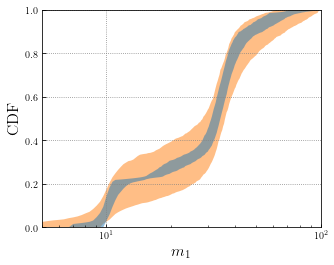

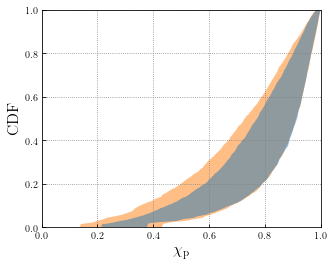

In [4]:
# Define a regular grid
m1_grid = np.linspace(0,100,300)
q_grid = np.linspace(0,1,300)

# Instantiate arrays to hold cdfs over the above grid
observed_m1_cdf = np.zeros((nPops,m1_grid.size))
observed_q_cdf = np.zeros((nPops,q_grid.size))
predicted_m1_cdf = np.zeros((nPops,m1_grid.size))
predicted_q_cdf = np.zeros((nPops,q_grid.size))

# For each of our catalogs, compute CDFs
for i in range(nPops):
    
    cdf_vals = np.cumsum(np.ones(len(sampleDict)))/len(sampleDict)
    
    observed_m1_cdf[i,:] = np.interp(m1_grid,np.sort(observed_m1s[i,:]),cdf_vals,left=0)
    observed_q_cdf[i,:] = np.interp(q_grid,np.sort(observed_qs[i,:]),cdf_vals,left=0)
    predicted_m1_cdf[i,:] = np.interp(m1_grid,np.sort(predicted_m1s[i,:]),cdf_vals,left=0)
    predicted_q_cdf[i,:] = np.interp(q_grid,np.sort(predicted_qs[i,:]),cdf_vals,left=0)
    

# Plot!
fig,ax = plt.subplots(figsize=(5,4))
ax.fill_between(m1_grid,
                np.quantile(observed_m1_cdf,0.05,axis=0),
                np.quantile(observed_m1_cdf,0.95,axis=0),
                alpha=0.5
               )
ax.fill_between(m1_grid,
                np.quantile(predicted_m1_cdf,0.05,axis=0),
                np.quantile(predicted_m1_cdf,0.95,axis=0),
                zorder=-1,alpha=0.5
               )
ax.set_xlim(5,100)
ax.set_ylim(0,1)
ax.set_xscale('log')
ax.set_xlabel('$m_1$',fontsize=16)
ax.set_ylabel('CDF',fontsize=16)
plt.show()

fig,ax = plt.subplots(figsize=(5,4))
ax.fill_between(q_grid,
                np.quantile(observed_q_cdf,0.05,axis=0),
                np.quantile(observed_q_cdf,0.95,axis=0),
                alpha=0.5
               )
ax.fill_between(q_grid,
                np.quantile(predicted_q_cdf,0.05,axis=0),
                np.quantile(predicted_q_cdf,0.95,axis=0),
                zorder=-1,alpha=0.5
               )
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('$\chi_\mathrm{p}$',fontsize=16)
ax.set_ylabel('CDF',fontsize=16)
plt.show()

## Make predictive check figure

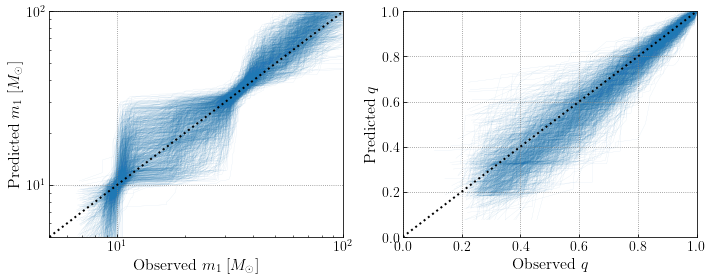

In [5]:
# Set up figure
fig = plt.figure(figsize=(10,4))

# Subplot to show primary mass predictive check
ax = fig.add_subplot(121)
ax.set_rasterization_zorder(2)

# For each random population, compare sorted "predicted" and "observed" values
for i in range(nPops):
    ax.plot(np.sort(observed_m1s[i,:]),np.sort(predicted_m1s[i,:]),
            color='#1f78b4',alpha=0.2,lw=0.2,zorder=1)
    
# Misc formatting
ax.plot([5,100],[5,100],color='black',ls=':',lw=2)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'Observed $m_1$ $[M_\odot]$',fontsize=16)
ax.set_ylabel(r'Predicted $m_1$ $[M_\odot]$',fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(5,100)
ax.set_ylim(5,100)

# Subplot to show mass ratio predictive check
ax = fig.add_subplot(122)
ax.set_rasterization_zorder(2)
for i in range(nPops):
    
    # Compare predicted and observed catalogs
    ax.plot(np.sort(observed_qs[i,:]),np.sort(predicted_qs[i,:]),
            color='#1f78b4',alpha=0.2,lw=0.2,zorder=1)
    
# Formatting
ax.plot([0,1],[0,1],color='black',ls=':',lw=2)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'Observed $q$',fontsize=16)
ax.set_ylabel(r'Predicted $q$',fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

plt.tight_layout()
plt.savefig('figure_20.pdf',bbox_inches='tight',dpi=200)
plt.show()